# Train YOLOv8 Object Detection on a Dentex Dataset

Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.


## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv8
- CLI Basics
- Inference with Pre-trained COCO Model
- Roboflow Universe
- Preparing a custom dataset
- Custom Training
- Validate Custom Model
- Inference with Custom Model

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

## Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Wed Apr 17 06:30:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## HOME

In [4]:
import os
HOME = "/content/drive/MyDrive/V8"
%cd {HOME}

/content/drive/MyDrive/V8


## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **03.01.2024** with version **YOLOv8.0.196**.

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [7]:
# Pip install method (recommended)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.0/78.2 GB disk)


In [ ]:
# Git clone method (for development)

# %cd {HOME}
# !git clone github.com/ultralytics/ultralytics
# %cd {HOME}/ultralytics
# !pip install -e .

# from IPython import display
# display.clear_output()

# import ultralytics
# ultralytics.checks()

In [8]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started. Read more about CLI in [Ultralytics YOLO Docs](https://docs.ultralytics.com/usage/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

## Inference with Pre-trained COCO Model

### 💻 CLI

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

/content/drive/MyDrive/V8
100% 6.23M/6.23M [00:00<00:00, 154MB/s]
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

100% 104k/104k [00:00<00:00, 40.3MB/s]
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/drive/MyDrive/V8/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 95.1ms
Speed: 13.5ms preprocess, 95.1ms inference, 679.7ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


/content/drive/MyDrive/V8


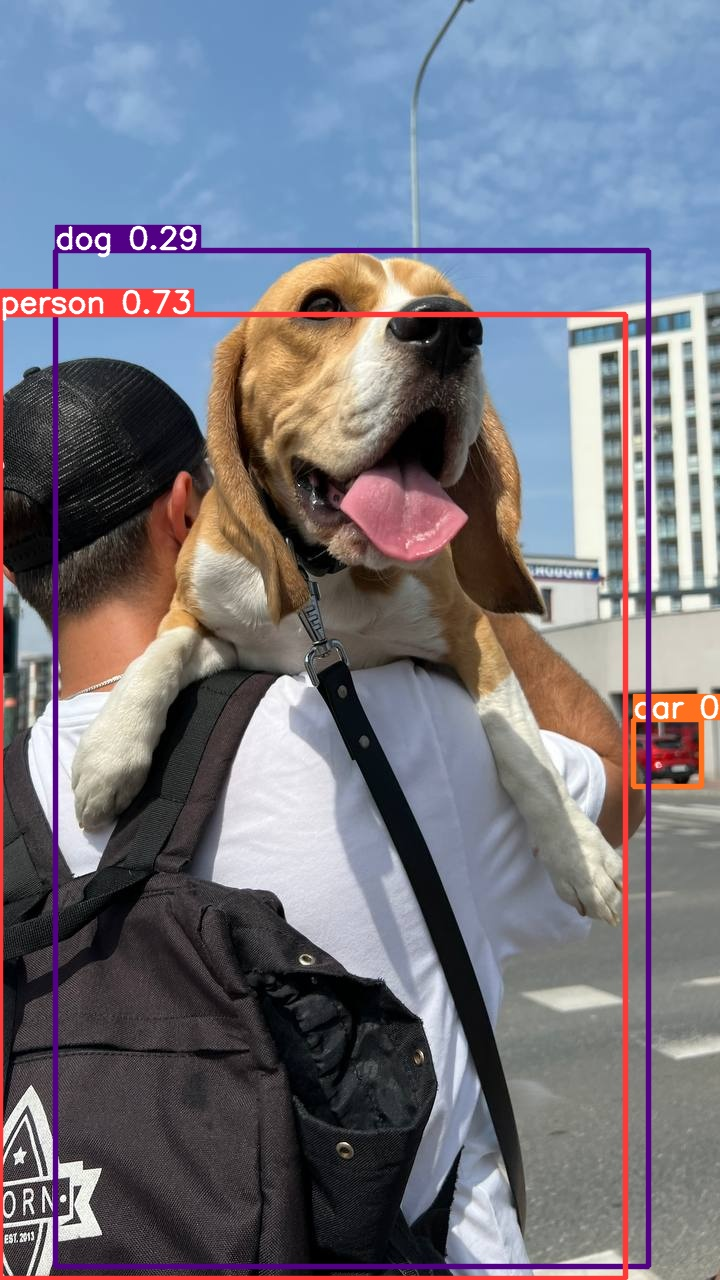

In [ ]:
%cd {HOME}
Image(filename='runs/detect/predict/dog.jpeg', height=600)

### 🐍 Python SDK

The simplest way of simply using YOLOv8 directly in a Python environment.

In [ ]:
model = YOLO(f'{HOME}/yolov8n.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg


In [ ]:
results[0].boxes.xyxy

tensor([[   0.,  314.,  625., 1278.],
        [  55.,  250.,  648., 1266.],
        [ 633.,  720.,  701.,  786.]], device='cuda:0')

In [ ]:
results[0].boxes.conf

tensor([0.72712, 0.29066, 0.28456], device='cuda:0')

In [ ]:
results[0].boxes.cls

tensor([ 0., 16.,  2.], device='cuda:0')

## Upload and unzip dataset

In [ ]:
!unzip "/content/drive/MyDrive/V8/datasets/DENTEX.zip" -d "/content/drive/MyDrive/V8/datasets/"

Archive:  /content/drive/MyDrive/V8/datasets/DENTEX.zip
   creating: /content/drive/MyDrive/V8/datasets/DENTEX/
   creating: /content/drive/MyDrive/V8/datasets/DENTEX/train/
   creating: /content/drive/MyDrive/V8/datasets/DENTEX/train/images/
  inflating: /content/drive/MyDrive/V8/datasets/DENTEX/train/images/train_100_png.rf.f15ecd9fef69b83b146963f159b194e9.jpg  
  inflating: /content/drive/MyDrive/V8/datasets/DENTEX/train/images/train_102_png.rf.b69c118fe09a758ede7b475a492dccfa.jpg  
  inflating: /content/drive/MyDrive/V8/datasets/DENTEX/train/images/train_103_png.rf.2f8dd953746c5fbf8db00fa395255d8e.jpg  
  inflating: /content/drive/MyDrive/V8/datasets/DENTEX/train/images/train_104_png.rf.031e9a985a7032ff61e35e1871d04dcd.jpg  
  inflating: /content/drive/MyDrive/V8/datasets/DENTEX/train/images/train_106_png.rf.8d03b39d617578ebf4786bc700bd4d01.jpg  
  inflating: /content/drive/MyDrive/V8/datasets/DENTEX/train/images/train_107_png.rf.8a45bbe1b1fd3870eeb00c117ea9908d.jpg  
  inflating: 

## Custom Training

In [12]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8m.pt data=/content/drive/MyDrive/V8/datasets/DENTEX/data.yaml epochs=50 imgsz=800 plots=True batch=16

In [ ]:
!ls {HOME}/runs/detect/train2/

args.yaml					     PR_curve.png	  train_batch2.jpg
confusion_matrix_normalized.png			     R_curve.png	  val_batch0_labels.jpg
confusion_matrix.png				     results.csv	  val_batch0_pred.jpg
events.out.tfevents.1711646714.636b6b08ba3e.17794.0  results.png	  val_batch1_labels.jpg
events.out.tfevents.1711652108.0abc06afacde.8512.0   train_batch0.jpg	  val_batch1_pred.jpg
F1_curve.png					     train_batch1440.jpg  val_batch2_labels.jpg
labels_correlogram.jpg				     train_batch1441.jpg  val_batch2_pred.jpg
labels.jpg					     train_batch1442.jpg  weights
P_curve.png					     train_batch1.jpg


/content/drive/MyDrive/V8


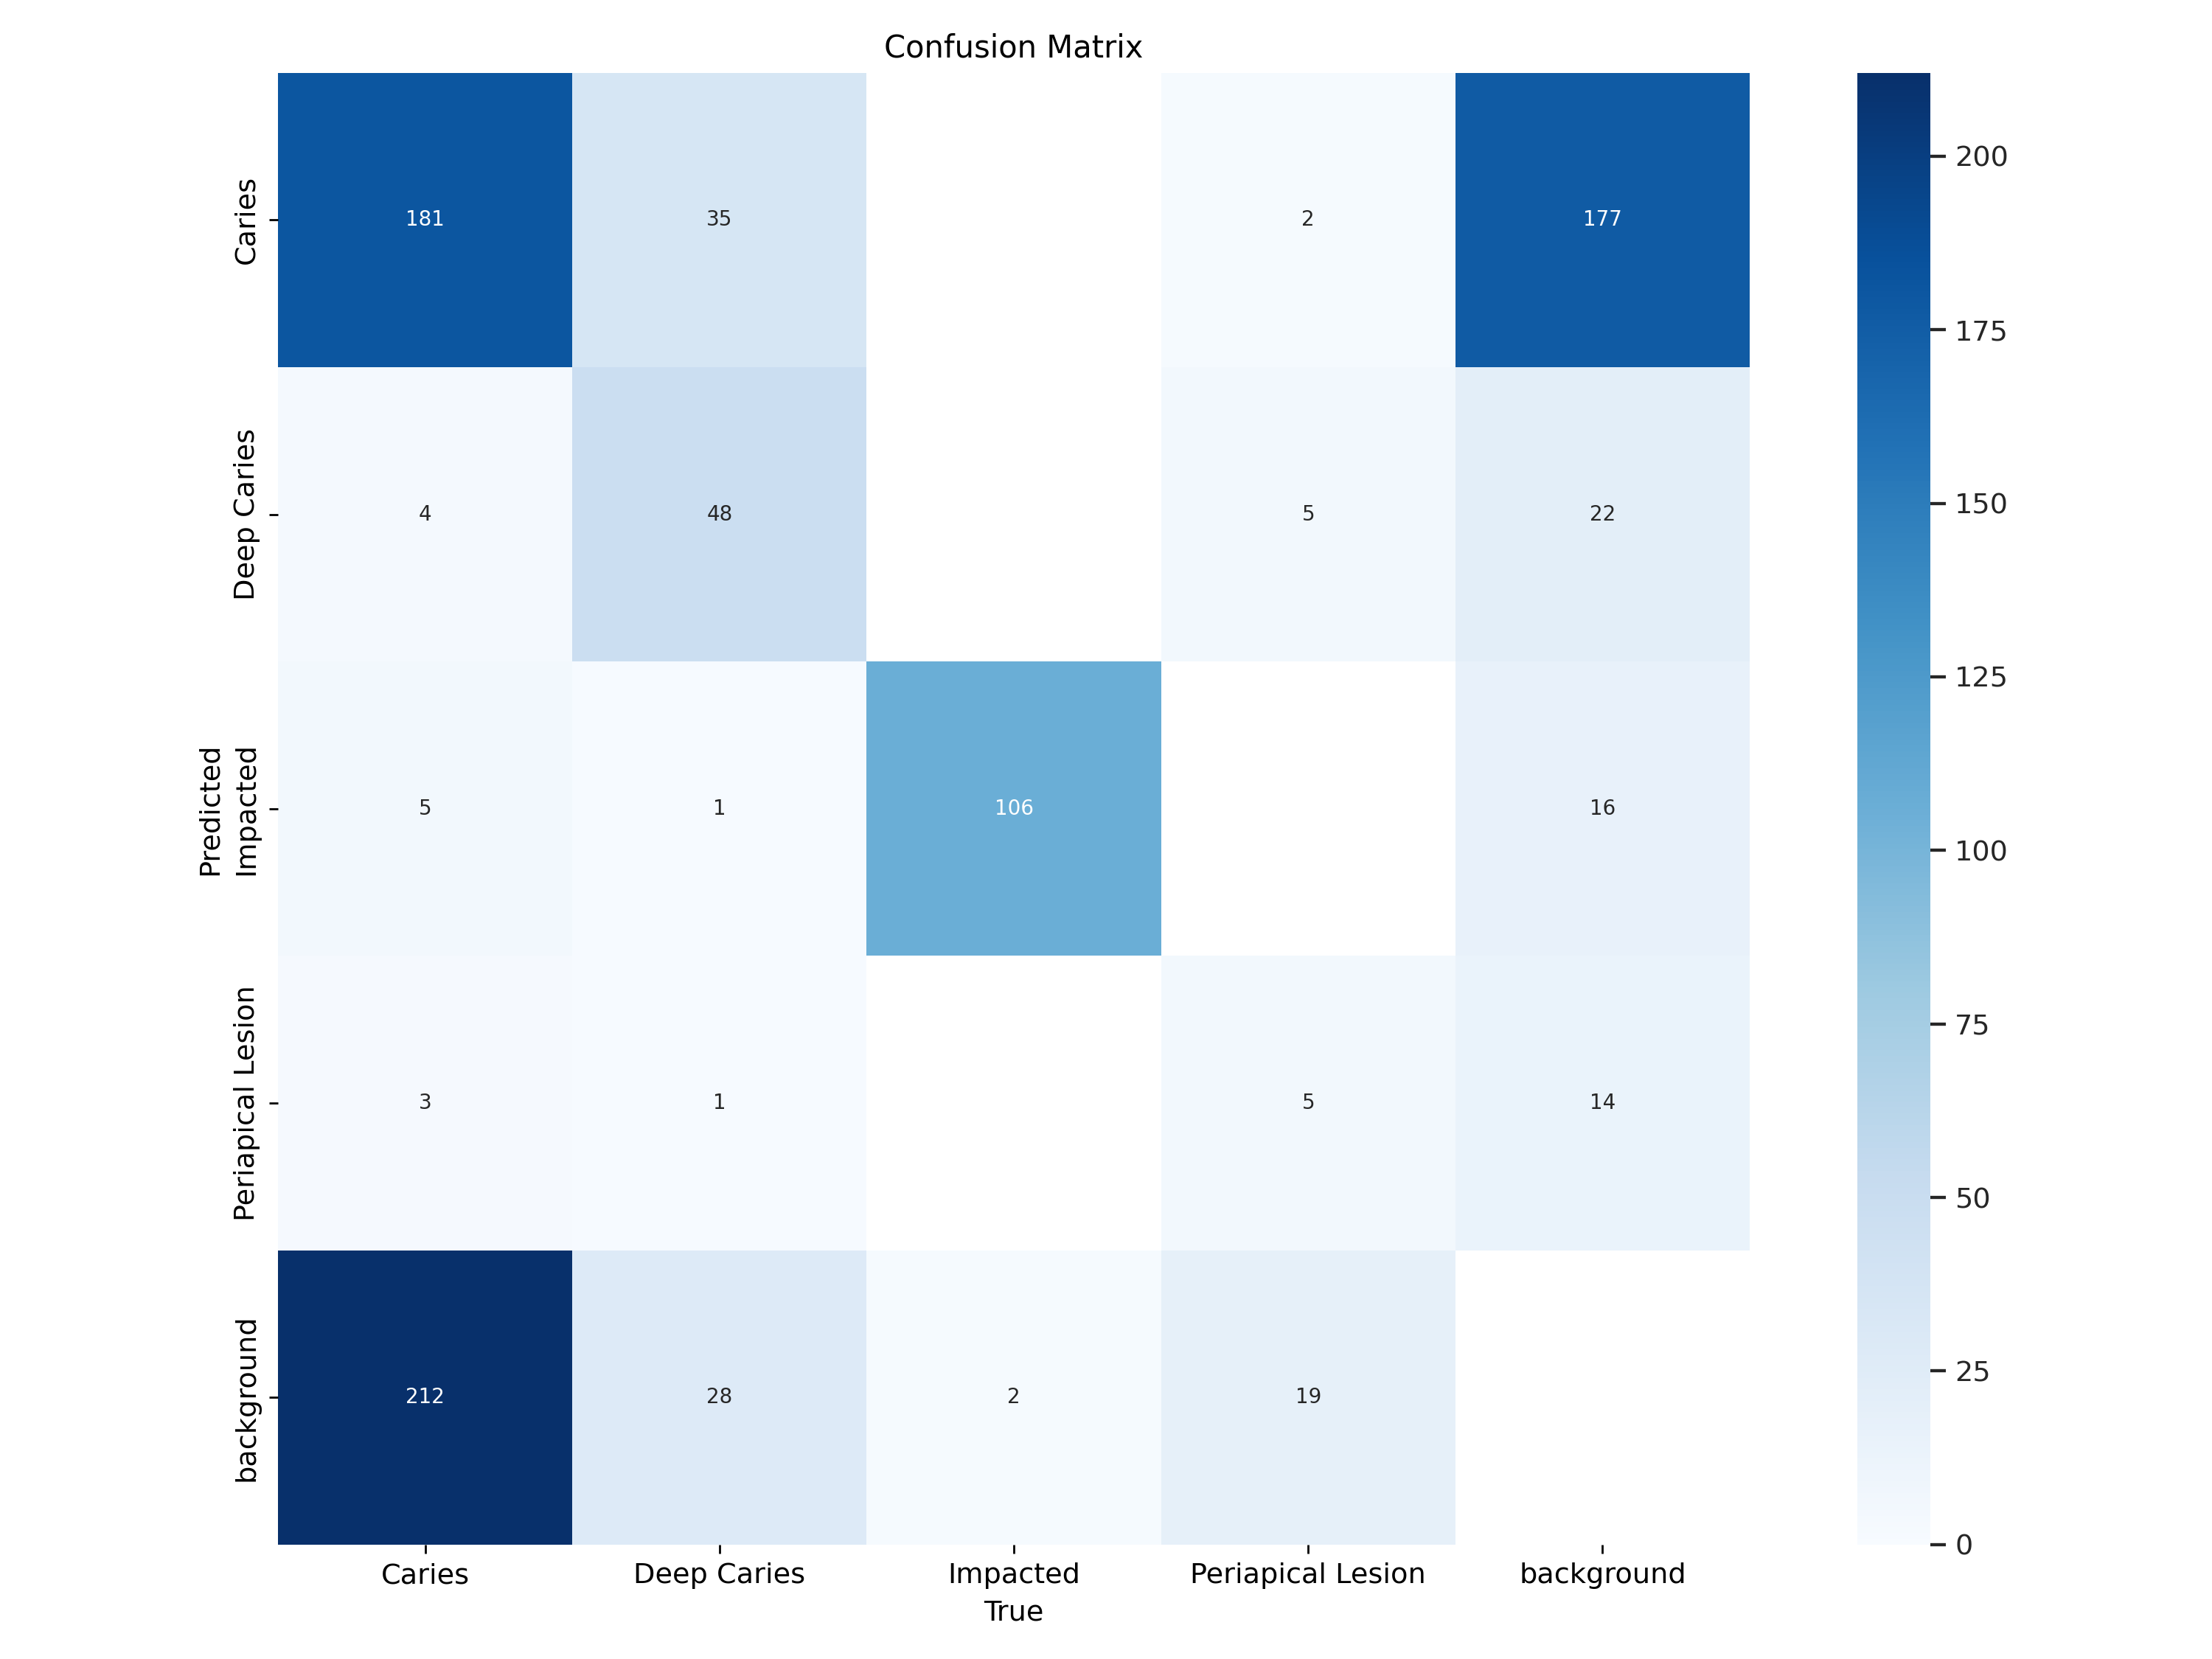

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=600)

/content/drive/MyDrive/V8


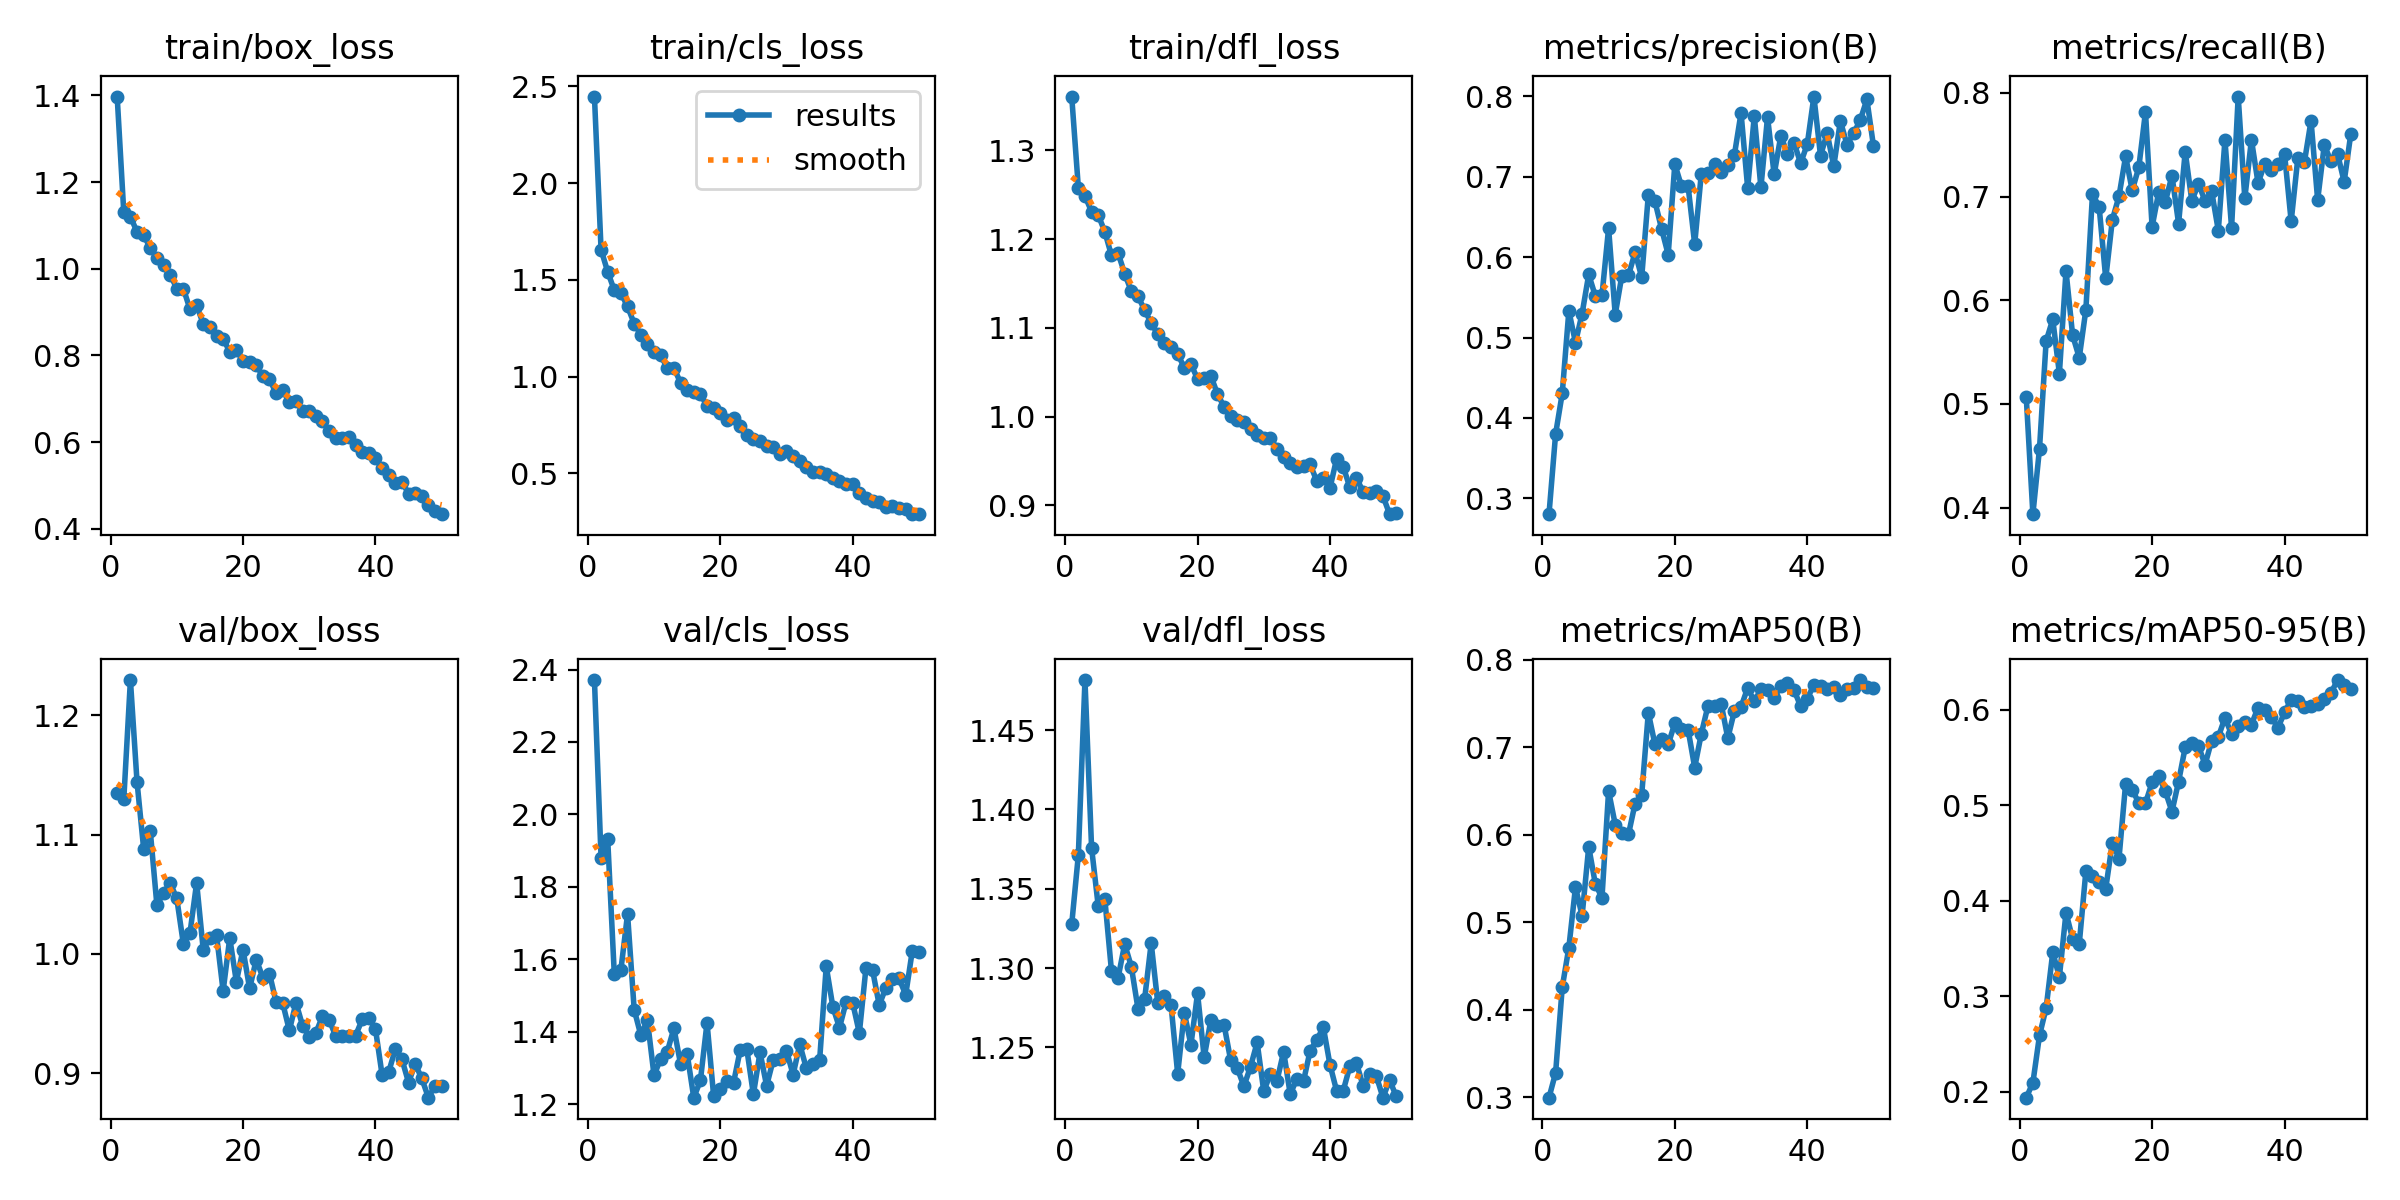

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

/content/drive/MyDrive/V8


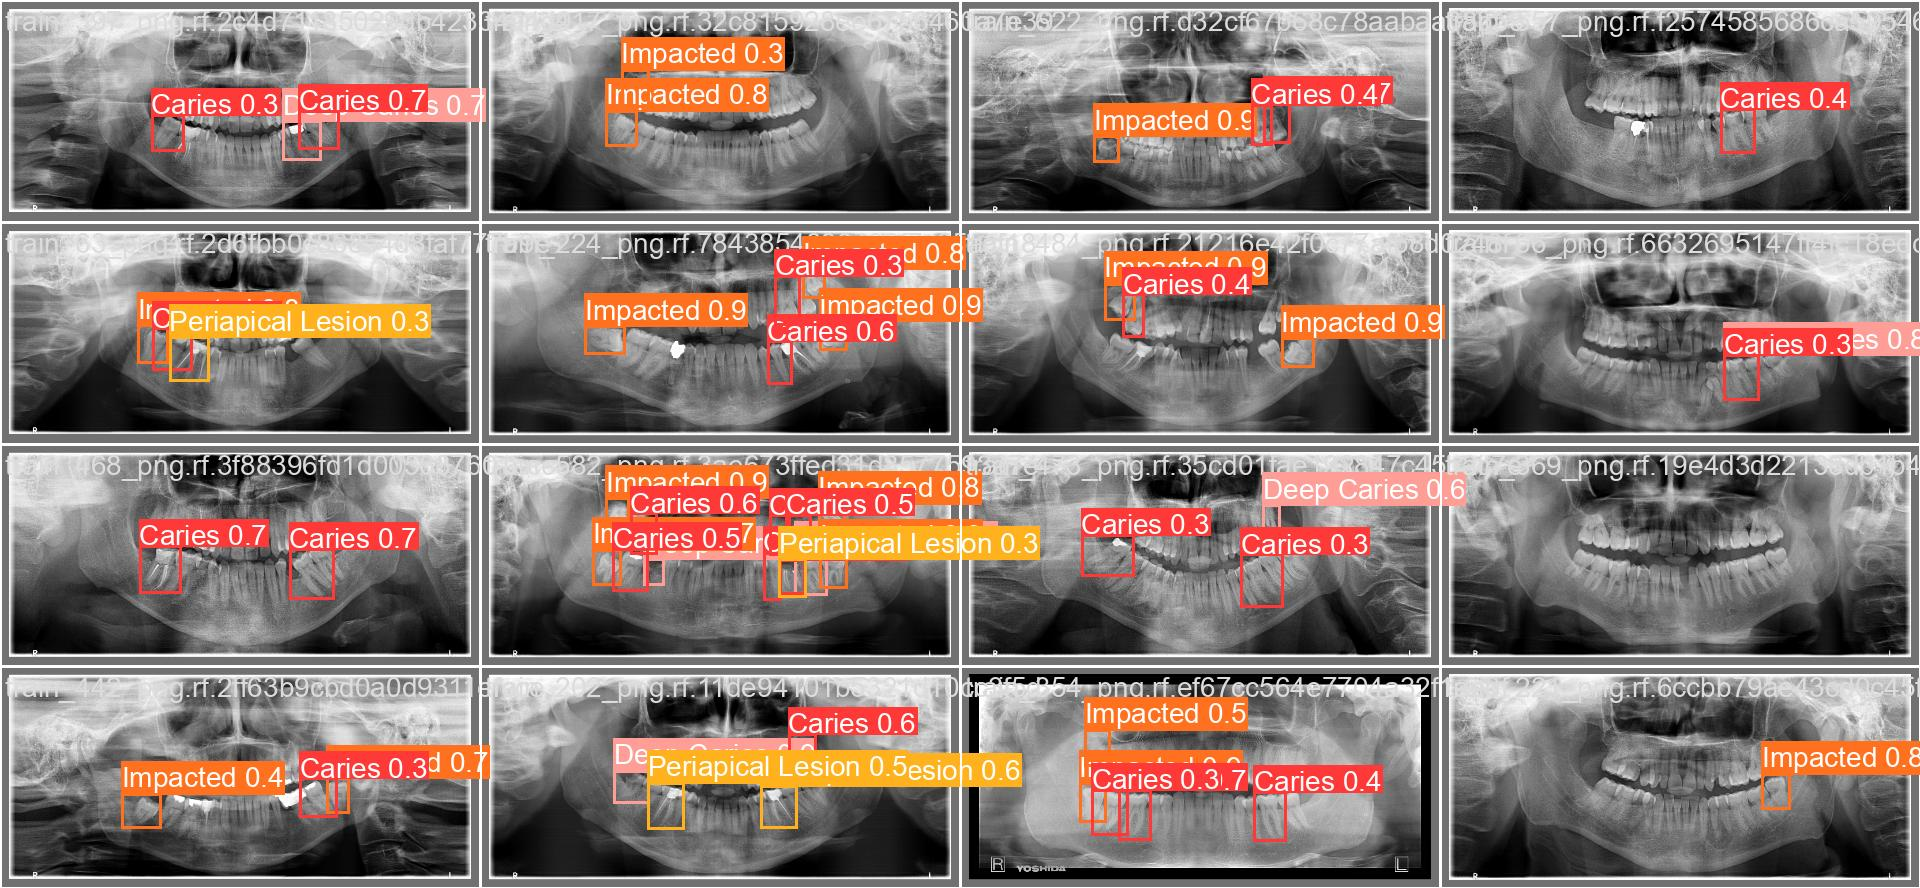

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train2/weights/best.pt data=/content/drive/MyDrive/V8/datasets/dentex-dataset-1/data.yaml

/content/drive/MyDrive/V8
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43609692 parameters, 0 gradients, 164.8 GFLOPs
val: Scanning /content/drive/MyDrive/V8/datasets/dentex-dataset-1/valid/labels.cache... 139 images, 9 backgrounds, 0 corrupt: 100% 139/139 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0% 0/9 [00:00<?, ?it/s]WARNING ⚠️ NMS time limit 1.300s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 9/9 [00:12<00:00,  1.34s/it]
                   all        139        657      0.557       0.55      0.509      0.347
                Caries        139        405       0.41      0.496      0.419      0.319
           Deep Caries        139        113      0.726      0.539      0.578      0.367
              Impacted        139        108      0.722      0.843       0.76      0.503
     Periap

## Inference with Custom Model

In [10]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train6/weights/best.pt conf=0.25 source=/content/drive/MyDrive/V8/datasets/DENTEX/valid/images save=True

/content/drive/MyDrive/V8
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/139 /content/drive/MyDrive/V8/datasets/DENTEX/valid/images/train_0_png.rf.b46543dd5d0fe4f45adb49d1f23a6bc2.jpg: 384x800 2 Cariess, 76.4ms
image 2/139 /content/drive/MyDrive/V8/datasets/DENTEX/valid/images/train_101_png.rf.0b522dfafc90092f5f8cdeeb7e0bb792.jpg: 384x800 4 Cariess, 2 Deep Cariess, 29.4ms
image 3/139 /content/drive/MyDrive/V8/datasets/DENTEX/valid/images/train_105_png.rf.c5e36d2ff7bb22b8492b24e1bc875cf4.jpg: 384x800 4 Cariess, 2 Impacteds, 29.4ms
image 4/139 /content/drive/MyDrive/V8/datasets/DENTEX/valid/images/train_108_png.rf.74734025413b9d1d9d2a3952ec310935.jpg: 384x800 3 Cariess, 29.3ms
image 5/139 /content/drive/MyDrive/V8/datasets/DENTEX/valid/images/train_10_png.rf.7fe94206ad9f22023662c39929b2eca3.jpg: 384x800 4 Cariess, 29.

**NOTE:** Let's take a look at few results.

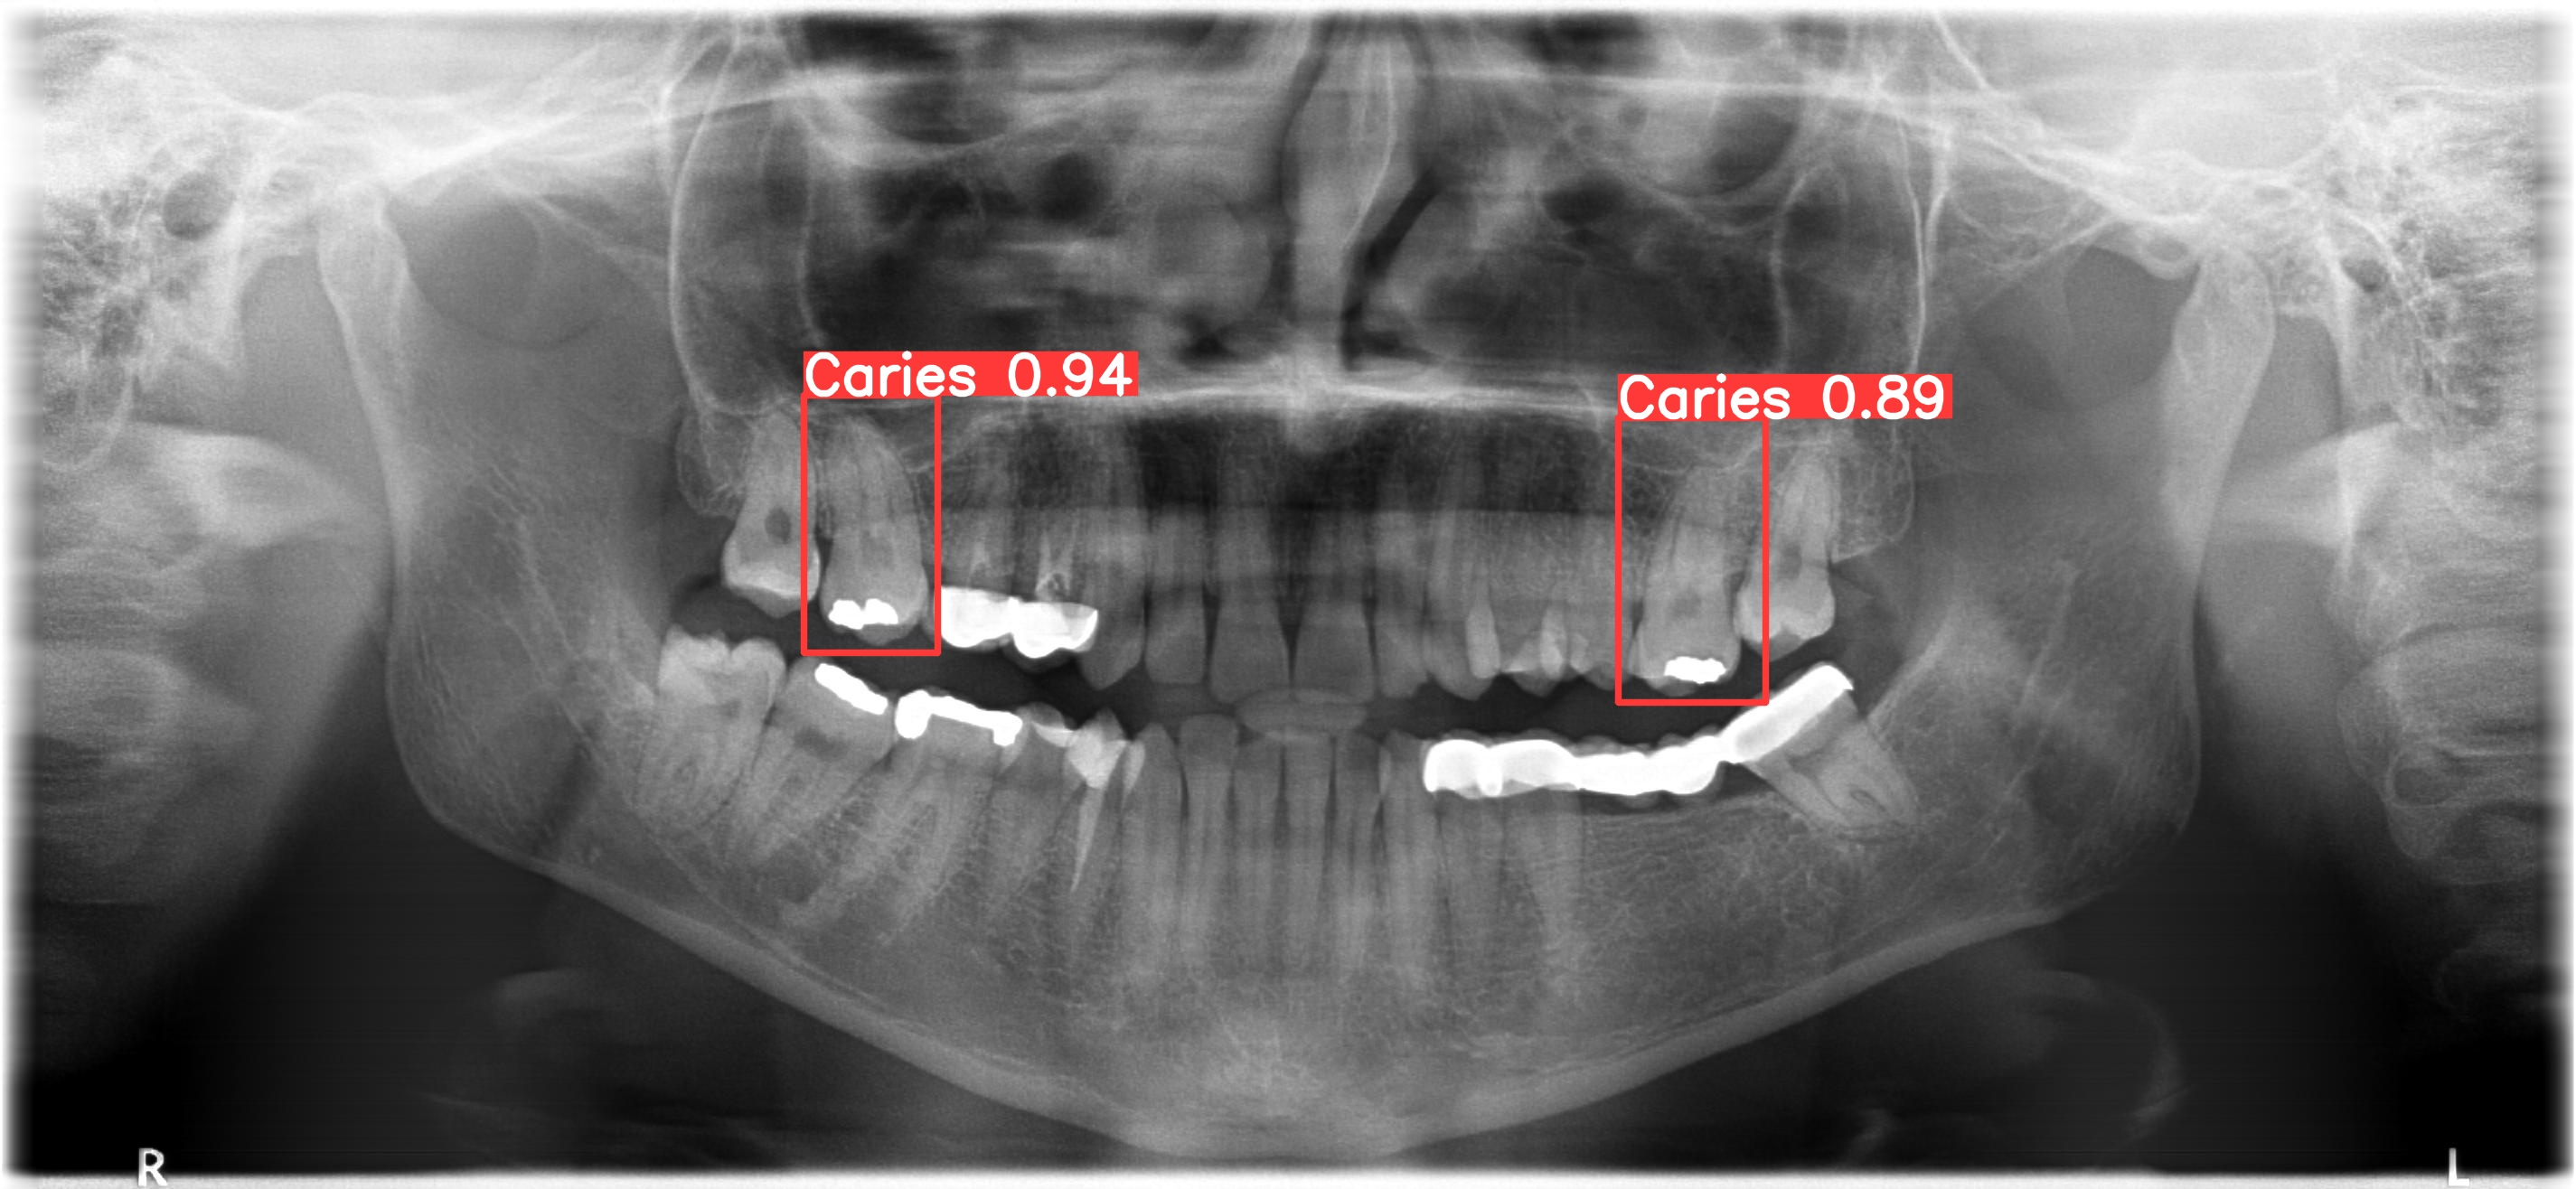

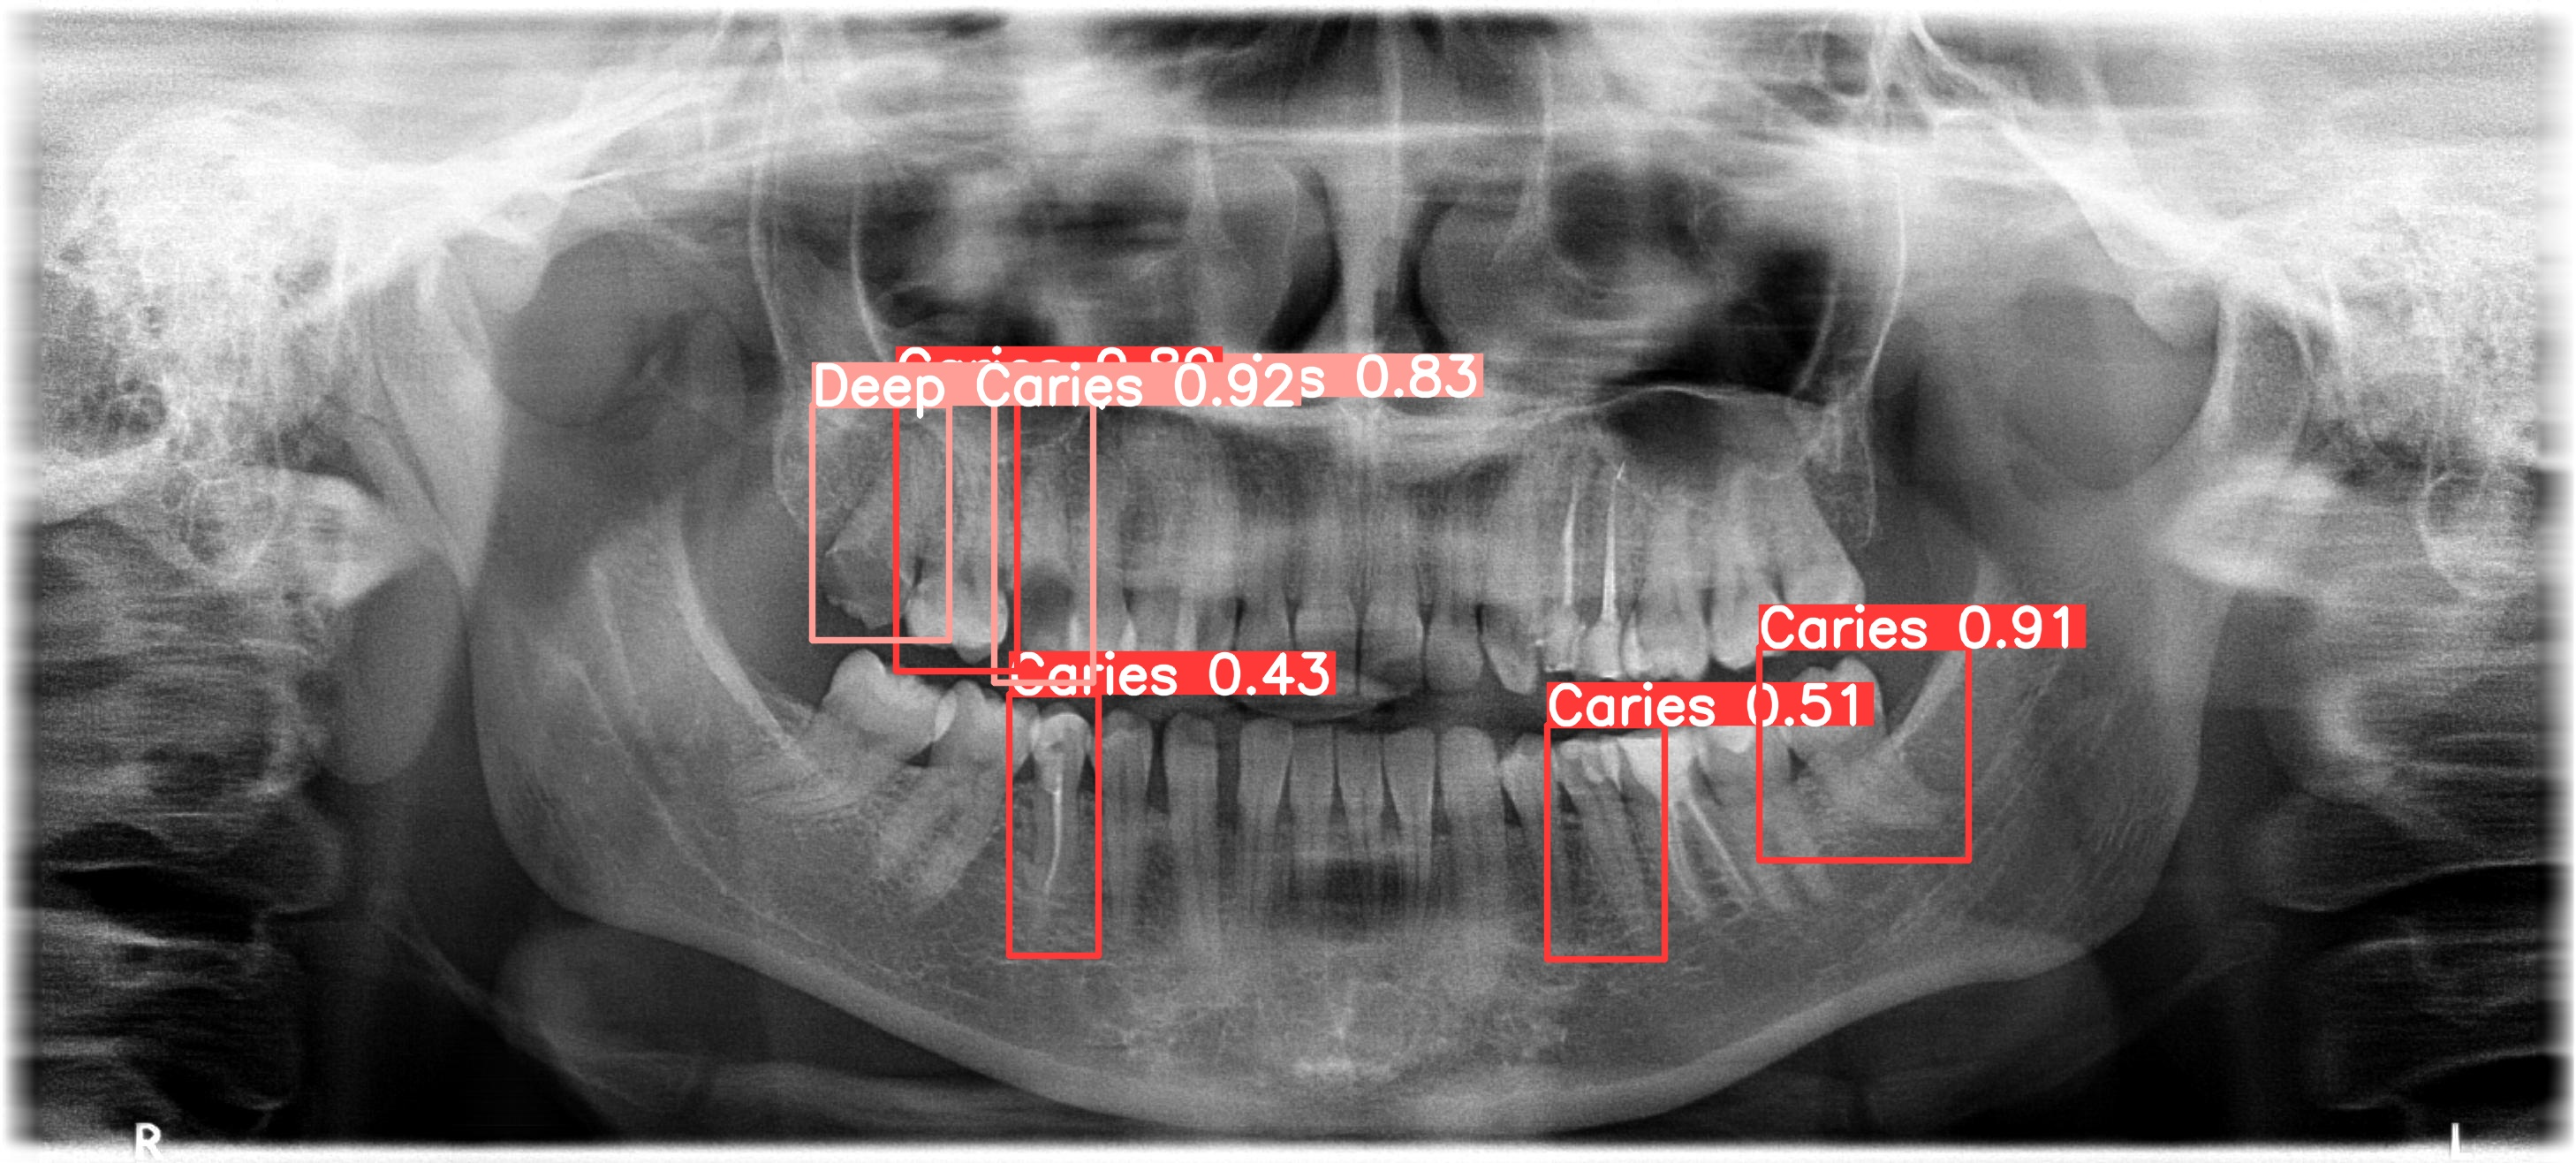

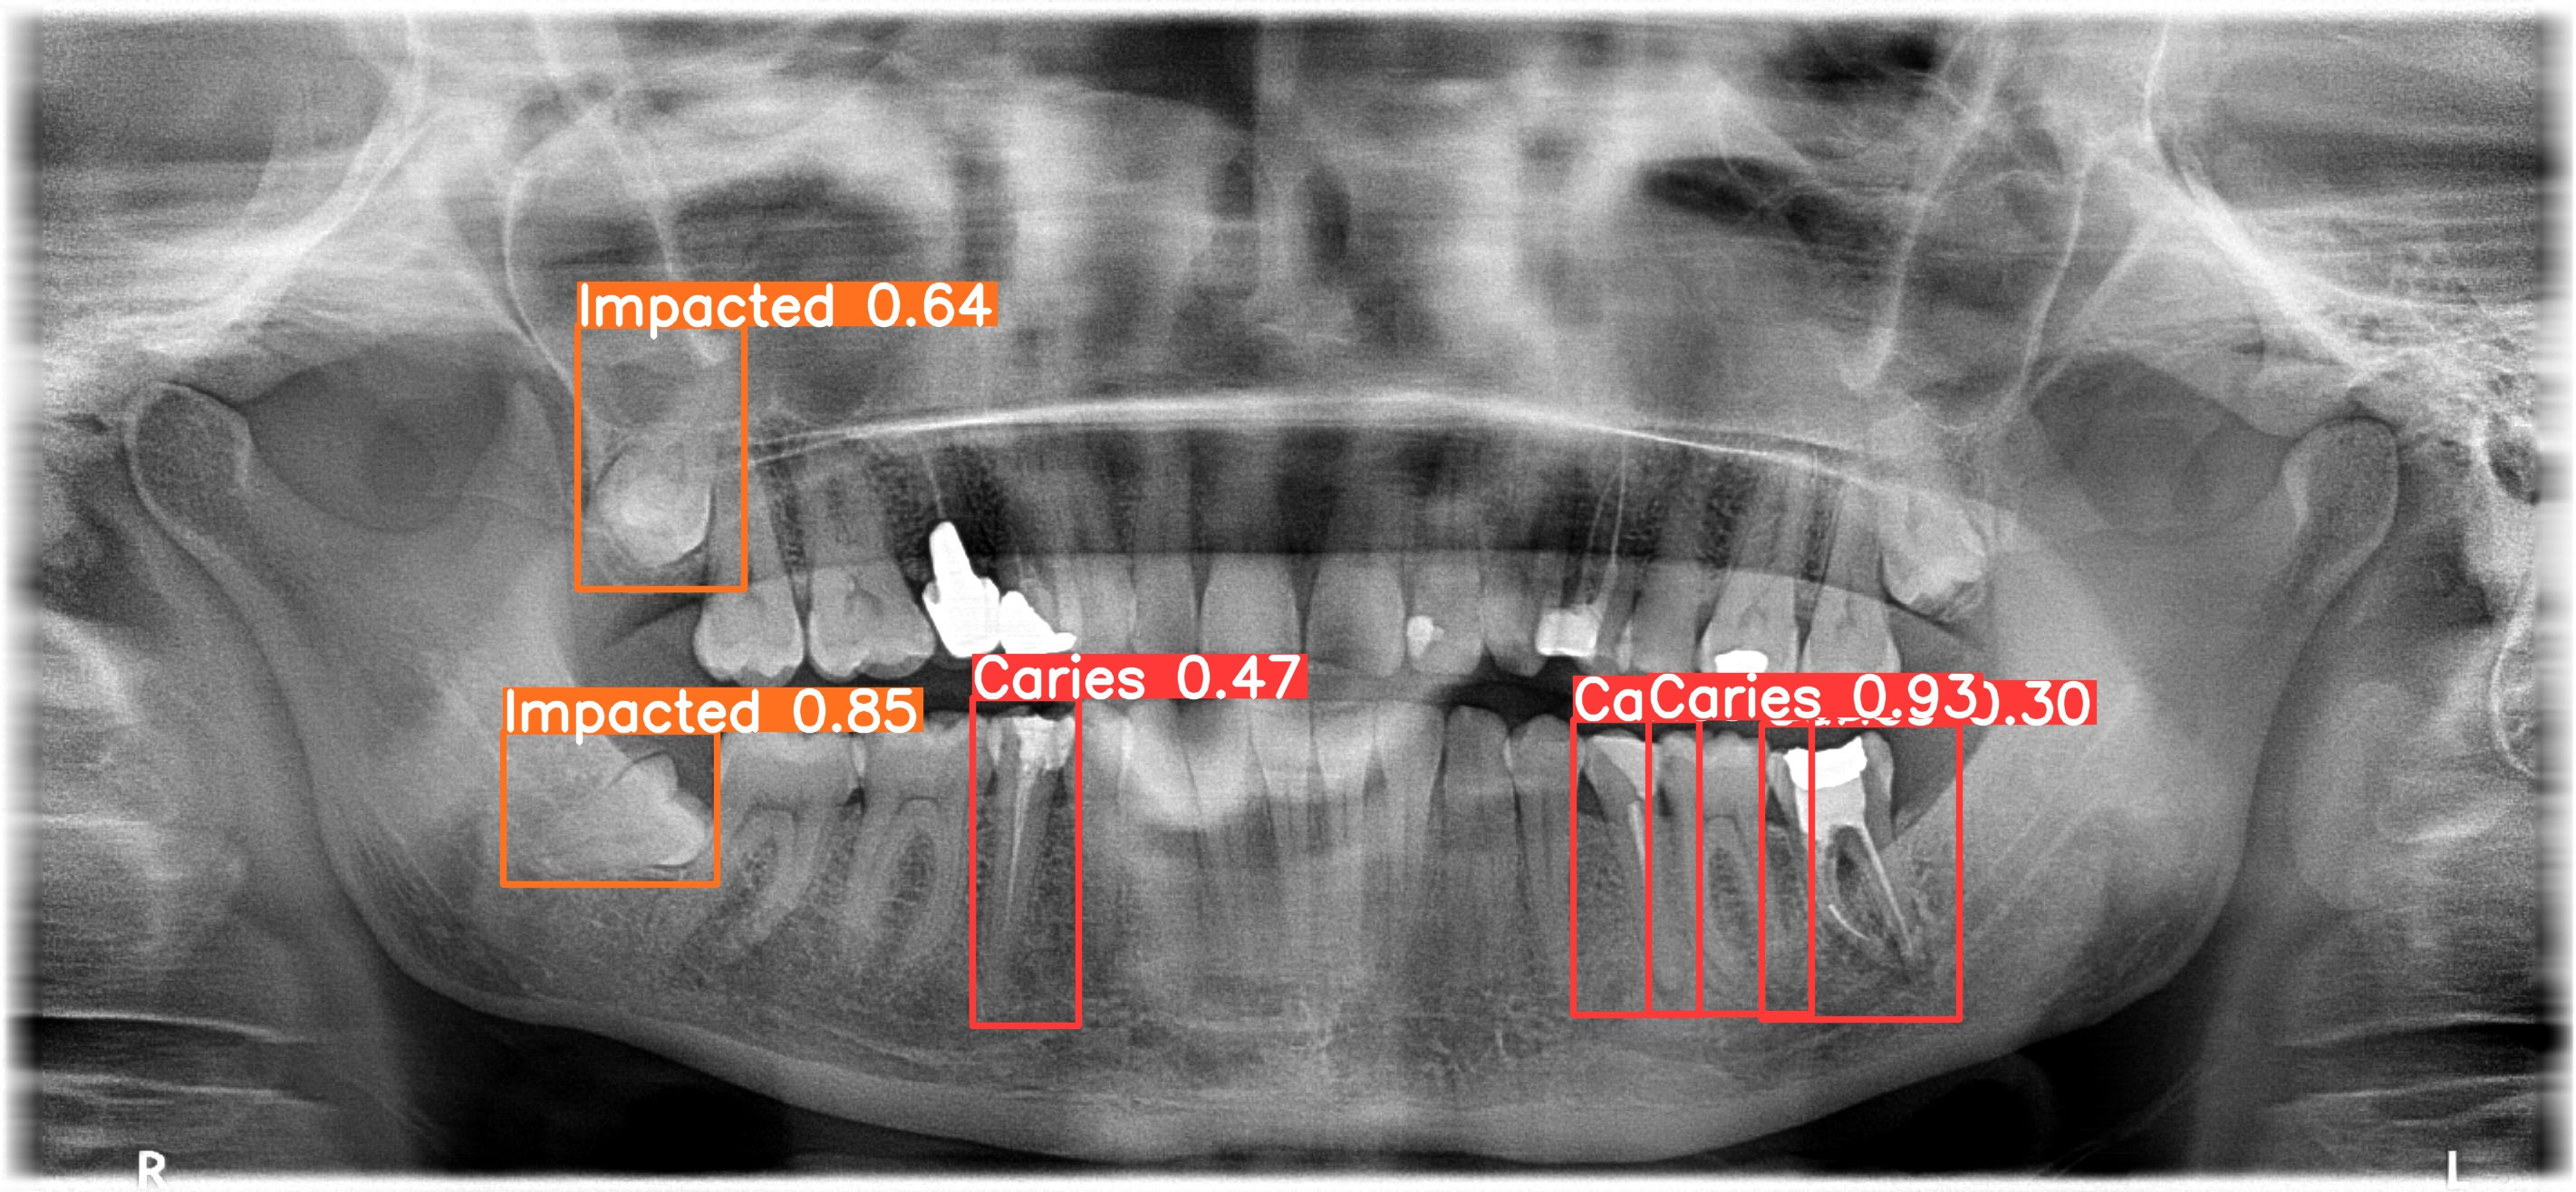

In [11]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict2/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")